In [1]:
# Graph_Classification_GCN_MaxPool.ipynb

# 📦 1. Εισαγωγή απαραίτητων βιβλιοθηκών
import torch
import torch.nn.functional as F




ModuleNotFoundError: No module named 'torch_geometric'

In [2]:
# Install torch-scatter
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
# Install torch-sparse
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
# Install torch-cluster
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
# Install torch-spline-conv
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
# Install torch-geometric
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.3 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.4 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00


In [3]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool
import matplotlib.pyplot as plt

In [4]:
# ⚙️ 2. Ρυθμίσεις
torch.manual_seed(42)

# 📚 3. Φόρτωση dataset (MUTAG: μικρά γραφήματα μορίων, 2 κατηγορίες)
dataset = TUDataset(root='data/TUD', name='MUTAG')
dataset = dataset.shuffle()

num_classes = dataset.num_classes
num_node_features = dataset.num_node_features

# 📦 4. Διαχωρισμός σε train/test
split_idx = int(0.8 * len(dataset))
train_loader = DataLoader(dataset[:split_idx], batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset[split_idx:], batch_size=32, shuffle=False)



Processing...
Done!


In [5]:
# 🧠 5. Ορισμός GCN μοντέλου με Dropout και MaxPooling
class GCN_MaxPool(torch.nn.Module):
    def __init__(self, in_feats, hidden, out_classes, dropout_p=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.dropout = torch.nn.Dropout(dropout_p)
        self.lin = torch.nn.Linear(hidden, out_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 📌 GCN Layers με ReLU και Dropout
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)

        # 📌 Global Max Pooling: από κόμβους -> γράφημα
        x = global_max_pool(x, batch)

        # 📌 Dropout και τελική ταξινόμηση
        x = self.dropout(x)
        x = self.lin(x)
        return x  # επιστρέφουμε logits

# 🔧 6. Αρχικοποίηση μοντέλου, optimizer και loss
model = GCN_MaxPool(num_node_features, hidden=64, out_classes=num_classes, dropout_p=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()



In [6]:
# 🎓 7. Συνάρτηση εκπαίδευσης
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)              # logits
        loss = criterion(out, data.y)  # labels
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# 🧪 8. Συνάρτηση αξιολόγησης
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

# 📈 9. Εκπαίδευση για 200 εποχές
train_accs = []
test_accs = []
for epoch in range(1, 201):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")




Epoch 001 | Loss: 0.6668 | Train Acc: 0.693 | Test Acc: 0.553
Epoch 020 | Loss: 0.5831 | Train Acc: 0.693 | Test Acc: 0.553
Epoch 040 | Loss: 0.5444 | Train Acc: 0.707 | Test Acc: 0.579
Epoch 060 | Loss: 0.5388 | Train Acc: 0.780 | Test Acc: 0.658
Epoch 080 | Loss: 0.4843 | Train Acc: 0.773 | Test Acc: 0.737
Epoch 100 | Loss: 0.4809 | Train Acc: 0.773 | Test Acc: 0.737
Epoch 120 | Loss: 0.4548 | Train Acc: 0.773 | Test Acc: 0.737
Epoch 140 | Loss: 0.4820 | Train Acc: 0.773 | Test Acc: 0.737
Epoch 160 | Loss: 0.4484 | Train Acc: 0.780 | Test Acc: 0.737
Epoch 180 | Loss: 0.4686 | Train Acc: 0.780 | Test Acc: 0.711
Epoch 200 | Loss: 0.4676 | Train Acc: 0.780 | Test Acc: 0.711


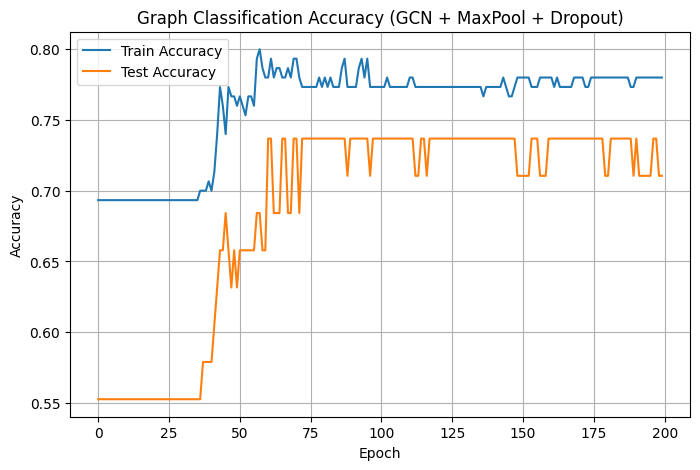

In [7]:
# 📊 10. Οπτικοποίηση απόδοσης
plt.figure(figsize=(8, 5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Graph Classification Accuracy (GCN + MaxPool + Dropout)')
plt.legend()
plt.grid(True)
plt.show()